In [17]:
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis import Universe
from freud.cluster import Cluster
import freud
from glob import glob
from natsort import natsorted
from tqdm.auto import tqdm
from collections import Counter
from scipy.optimize import curve_fit
import pickle

plt.style.use("mystyle")

# functions

In [16]:
def calc_clusters(traj, N, Nres, Nchains, rcut, frames=10000, skip=1):
    time = []
    x_high = []
    for frame in tqdm(traj.trajectory[-frames::skip], leave=False):
        pos = traj.select_atoms("all").positions
        system = freud.AABBQuery(box, pos)
        cl = freud.cluster.Cluster()
        cl.compute(system, neighbors={"r_max": rcut})

        count = []
        number = []
        for ctr, cluster_id in enumerate(range(cl.num_clusters)):
            number.append(len(system.points[cl.cluster_keys[cluster_id]]))
            count.append(ctr+1)
        count = np.array(count)
        number = np.array(number)/Nres
        
        time.append(frame.time*1e-6)

        x_high.append(number[number > 10].sum())

    time = np.array(time)
    x_high = np.array(x_high)/Nchains
    x_low = 1 - x_high

    return time, x_high, x_low

# obtaining system information

In [3]:
temp = natsorted(glob("sims/llps_plus/for_expt/prot28_rudra/calvados/[0-9]*"))[:-3]

In [4]:
system = Universe(f"{temp[0]}/multi.pdb")

box = system.trajectory[0]._unitcell[:3]
box = freud.box.Box(Lx=box[0], Ly=box[1], Lz=box[2])
N = system.select_atoms("all").n_atoms
Nres = np.unique(system.residues.resids).shape[0]
Nchains = N//Nres

# clustering and calculating mol fractions

In [5]:
rcut = 6 # A

data = {}

for t in tqdm(temp):
    traj = Universe(f"{t}/multi.pdb", f"{t}/run0.xtc")
    time, x_high, x_low = calc_clusters(traj, N, Nres, Nchains, rcut, skip=100)

    data[float(t.split("/")[-1])] = {"time":time, "x_high":x_high, "x_low":x_low}
        
pickle.dump(data, open("sims/llps_plus/for_expt/prot28_rudra/calvados/mol_fractions.pkl", "wb"))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# plotting phase diagram

In [6]:
data = pickle.load(open("sims/llps_plus/for_expt/prot28_rudra/calvados/mol_fractions.pkl", "rb"))

In [24]:
def fit(T_and_low, A, Tc):
    T, low = T_and_low
    beta = 0.325
    return A*np.power(Tc - T, beta) + low

In [62]:
params, pcov = curve_fit(fit, (T, low), high, p0=(0.15, 220))
A, Tc = params
print(f"A={A:.2f}, Tc={Tc:.0f}")

A=0.28, Tc=215


/tmp/ipykernel_735478/867970399.py:4: RuntimeWarning: invalid value encountered in power
  return A*np.power(Tc - T, beta) + low


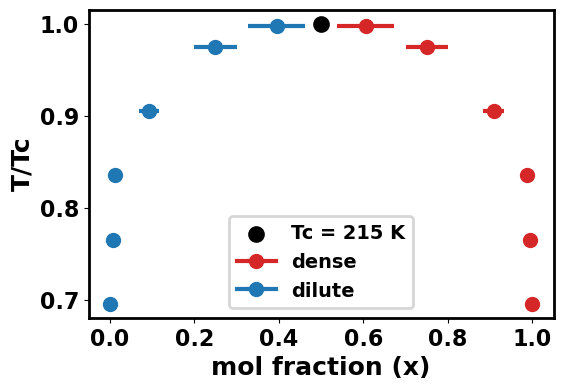

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

high, low, T = [], [], []
flag = True
for temp in data:
    T.append(temp)
    x_high = data[temp]["x_high"]
    x_low = data[temp]["x_low"]
    high.append(np.mean(x_high))
    low.append(np.mean(x_low))
    
    if flag:
        ax.errorbar(np.mean(x_high), temp/Tc, xerr=np.std(x_high), marker='o', markersize=10,
                    color="tab:red", label="dense")
        ax.errorbar(np.mean(x_low), temp/Tc, xerr=np.std(x_low), marker='o', markersize=10,
                    color="tab:blue", label="dilute")
        flag = False
    else:
        ax.errorbar(np.mean(x_high), temp/Tc, xerr=np.std(x_high), marker='o', markersize=10,
                    color="tab:red")
        ax.errorbar(np.mean(x_low), temp/Tc, xerr=np.std(x_low), marker='o', markersize=10,
                    color="tab:blue")

ax.set_xlabel("mol fraction (x)")
ax.set_ylabel("T/Tc")

ax.scatter(0.5, 1.0, color="black", label=f"Tc = {Tc:.0f} K")

ax.legend()

fig.savefig("figures/prot28_phase_diagram.png", dpi=300, bbox_inches="tight")
fig.savefig("figures/prot28_phase_diagram.svg", dpi=300, bbox_inches="tight")
fig.savefig("figures/prot28_phase_diagram.pdf", dpi=300, bbox_inches="tight")

plt.show()